In [1]:
import sys
import os 

sys.path.append('/home/klamdibih/Deep-Chemometrics')
import json
import src
from itertools import product
import pandas as pd
import json

In [2]:
import scipy as sp
import random
from torch import nn
from torch import optim
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import numpy as np
from src.utils import TrainerConfig
from src.training.training import Trainer
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import r2_score
from src.net import ViT_1D
from src.net.SWAG import SWAG

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


2025-06-17 10:37:51.747322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750149471.776783   10529 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750149471.785749   10529 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750149471.809238   10529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750149471.809281   10529 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750149471.809287   10529 computation_placer.cc:177] computation placer alr

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = sp.io.loadmat("../data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
print(data.keys())

Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]


dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


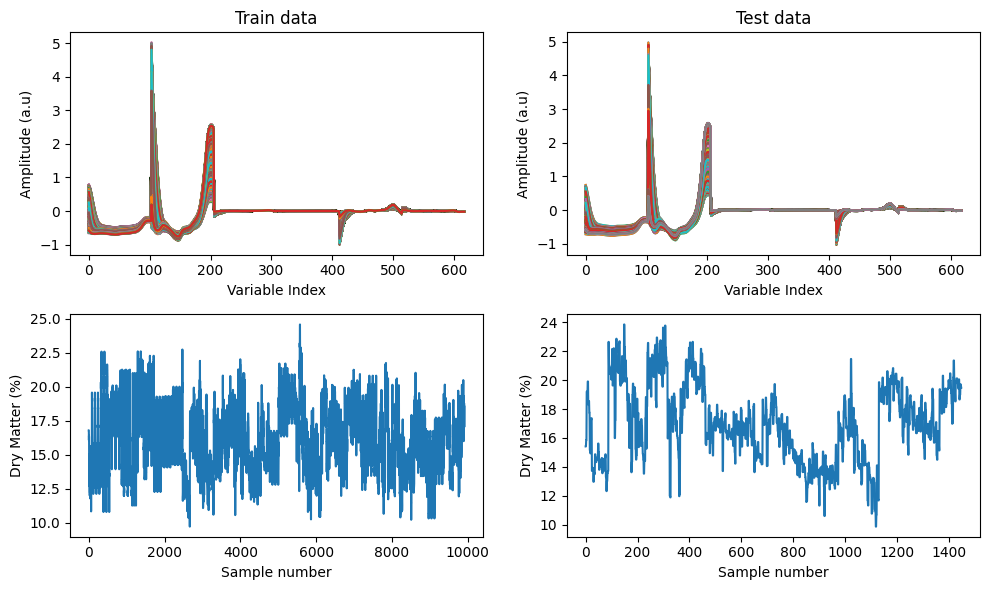

In [4]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()


In [5]:
## Spliting the train set
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42)

## The wavelenghts for the XX axis when we plot the spectra
x_scale = data['wave'].astype(np.float32).reshape(-1, 1)

# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))

In [6]:
os.makedirs("figure/vit1d", exist_ok=True)

## MC DROPOUT

In [7]:
with open("/home/klamdibih/Deep-Chemometrics/data/dataset/Mango/config/_ViT1D_Mango_jz(dm_mango).json", "r") as f:
    configs = json.load(f)


In [9]:
results_dp = []

# Training loop for each configuration
for cfg in configs:
    # Extract hyperparameters from current configuration
    patch_size = cfg["PS"]
    lr = cfg["LR"]
    dim_embed = cfg["DE"]
    trans_layers = cfg["TL"]
    heads = cfg["HDS"]
    mlp_dim = cfg["MLP"]
    dropout = cfg["DP"]
    emb_dropout = cfg["ED"]
    num_epochs = cfg["num_epochs"]
    
    print(f"\nTraining with patch_size: {patch_size}, learning_rate: {lr}")

    model_name = cfg["ID"]
    
    # Configure trainer
    config = TrainerConfig(model_name=model_name)
    config.update_config(
        batch_size=patch_size,
        num_epochs=num_epochs,
        save_model=True,
        classification=False,
        max_loss_plot=20
    )

    # Create data loaders
    cal_loader = data_utils.DataLoader(cal, batch_size=patch_size, shuffle=True)
    val_loader = data_utils.DataLoader(val, batch_size=patch_size, shuffle=False)

    
    model = ViT_1D(
        mean=mean,
        std=std,
        seq_len=x_cal.shape[1],
        patch_size=patch_size,
        dim_embed=dim_embed,
        trans_layers=trans_layers,
        heads=heads,
        mlp_dim=mlp_dim,
        out_dims=1,
        channels=1,
        dim_head=dim_embed // heads,
        dropout=dropout,
        emb_dropout=emb_dropout
    ).to(config.device)

    # Setup optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
    criterion = torch.nn.MSELoss(reduction='mean')

    # Initialize trainer and start training
    trainer = Trainer(
        model=model, 
        optimizer=optimizer, 
        criterion=criterion,
        train_loader=cal_loader, 
        val_loader=val_loader, 
        config=config
    )

    train_losses, val_losses, val_r2_scores, final_path = trainer.train()

    # Load best model for uncertainty estimation
    model.load_state_dict(torch.load(final_path, map_location=config.device))
    model.train()  # Keep in training mode for MC Dropout

    # Monte Carlo Dropout for uncertainty estimation
    num_mc_samples = 100  
    predictions = np.zeros((len(val_loader.dataset), num_mc_samples))
    targets = np.zeros((len(val_loader.dataset), 1))

    # Perform MC Dropout sampling
    for mc_iter in range(num_mc_samples):
        sample_idx = 0
        
        for input_batch, target_batch in val_loader:
           
            input_batch = input_batch.to(config.device).float().unsqueeze(1)
            target_batch = target_batch.float()
            
            
            with torch.no_grad():
                output = model(input_batch)
                predictions[sample_idx:sample_idx + input_batch.size(0), mc_iter] = output.cpu().numpy().squeeze()
            
            targets[sample_idx:sample_idx + target_batch.size(0)] = target_batch.cpu().numpy().reshape(-1, 1)
            sample_idx += input_batch.size(0)

   
    mean_predictions = predictions.mean(axis=1)
    std_predictions = predictions.std(axis=1)
    
    
    rmse = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
    r2 = r2_score(targets.squeeze(), mean_predictions)
    
    
    lower_bound = mean_predictions - 3 * std_predictions
    upper_bound = mean_predictions + 3 * std_predictions
    coverage = ((targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)).mean() * 100
    
  
    avg_uncertainty = std_predictions.mean()

    # Store results for current configuration
    results_dp.append({
        "patch_size": patch_size,
        "learning_rate": lr,
        "RMSE": rmse,
        "STD": avg_uncertainty,
        "R2": r2,
        "Coverage": coverage
    })


df_mc_dropout = pd.DataFrame(results_dp)
df_mc_dropout.to_csv("result_csv/vit_result_mc_dropout.csv", index=False)



Training with patch_size: 4, learning_rate: 5e-05
Saving best model to /home/klamdibih/Deep-Chemometrics/models/_ViT1D_Mango_PS4_LR0p0001_best.pth


KeyboardInterrupt: 

In [ ]:
# Load ViT results
df_vit_results = pd.read_csv("result_csv/vit_result_mc_dropout.csv")

# Create output directory
os.makedirs("figure/vit_mc_dropout", exist_ok=True)

# Display and save heatmaps for each metric
for metric in ["RMSE", "STD", "Coverage"]:
    pivot = df_vit_results.pivot(
        index="patch_size", 
        columns="learning_rate", 
        values=metric
    )
    
    plt.figure(figsize=(6, 5), facecolor="white")
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"ViT {metric}")
    plt.xlabel("Learning Rate")
    plt.ylabel("Patch Size")
    plt.tight_layout()
    
    plt.savefig(f"figure/vit_mc_dropout/vit_{metric.lower()}_heatmap.pdf", dpi=500)
    plt.show()

## Model Averraging

In [10]:
def extract_params(cfg):
    # Extracts parameters from config
    return (
        cfg["PS"],
        cfg["DE"],
        cfg["TL"],
        cfg["HDS"],
        cfg["MLP"],
        cfg["LR"],
        cfg["DP"],
        cfg["ED"],
        cfg["num_epochs"]
    )

def build_model(cfg, mean, std, seq_len, device):
    # Instantiates ViT_1D model based on config
    patch_size, dim_embed, trans_layers, heads, mlp_dim, _, dropout, emb_dropout, _ = extract_params(cfg)
    return ViT_1D(
        mean=mean,
        std=std,
        seq_len=seq_len,
        patch_size=patch_size,
        dim_embed=dim_embed,
        trans_layers=trans_layers,
        heads=heads,
        mlp_dim=mlp_dim,
        out_dims=1,
        channels=1,
        dim_head=dim_embed // heads,
        dropout=dropout,
        emb_dropout=emb_dropout
    ).to(device)


N_models_list = [10, 30, 50, 100]
results_stacking = []

# Phase 1: Training and saving base models
for cfg in configs:
    (patch_size, dim_embed, trans_layers, heads,
     mlp_dim, LR, dropout, emb_dropout, num_epochs) = extract_params(cfg)

    print(f"Training BASE ViT_1D: patch_size={patch_size}, LR={LR}")

    set_seed(42)
    config.update_config(batch_size=patch_size)

    model = build_model(cfg, mean, std, x_cal.shape[1], config.device)

    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.015)
    criterion = nn.MSELoss(reduction='mean')

    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion,
                      train_loader=cal_loader, val_loader=val_loader, config=config)

    for epoch in range(num_epochs):
        trainer.train_one_epoch()

    model_name = f"{cfg['ID']}.pt"
    os.makedirs("notebook/ensemble_models", exist_ok=True)
    torch.save(model.state_dict(), f"notebook/ensemble_models/{model_name}")

# Phase 2: Stacking with saved base models
for cfg in configs:
    (patch_size, dim_embed, trans_layers, heads,
     mlp_dim, LR, dropout, emb_dropout, _) = extract_params(cfg)

    for N_models in N_models_list:
        print(f"ViT_1D: patch_size={patch_size}, "
               f"LR={LR}, N_models={N_models}")

        set_seed(42)
        config.update_config(batch_size=patch_size)

        model = build_model(cfg, mean, std, x_cal.shape[1], config.device)

        model_path = f"notebook/ensemble_models/{cfg['ID']}.pt"
        model.load_state_dict(torch.load(model_path, map_location=config.device))

        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.015)
        criterion = nn.MSELoss(reduction='mean')

        trainer = Trainer(model, optimizer, criterion, cal_loader, val_loader, config)

        # Ensemble training and prediction
        list_of_models = []
        for epoch in range(N_models):
            trainer.train_one_epoch()
            list_of_models.append(copy.deepcopy(model.to("cpu")))

        predictions = np.zeros((len(val_loader.dataset), N_models))
        targets = np.zeros((len(val_loader.dataset), 1))

        with torch.no_grad():
            for k, model_k in enumerate(list_of_models):
                model_k.to(config.device)
                model_k.eval()
                idx = 0
                for input, target in val_loader:
                    input = input.to(config.device).float().unsqueeze(1)
                    target = target.float()
                    output = model_k(input)
                    predictions[idx:idx + input.size(0), k] = output.cpu().numpy().squeeze()
                    targets[idx:idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                    idx += input.size(0)

        # Metrics
        mean_pred = predictions.mean(axis=1)
        std_pred = predictions.std(axis=1)
        rmse = np.sqrt(np.mean((mean_pred - targets.squeeze()) ** 2))
        r2 = r2_score(targets.squeeze(), mean_pred)
        coverage = ((targets[:, 0] >= mean_pred - 3 * std_pred) &
                    (targets[:, 0] <= mean_pred + 3 * std_pred)).mean() * 100

        results_stacking.append({
            "patch_size": patch_size,
            "lr": LR,
            "n_models": N_models,
            "rmse": rmse,
            "R2" : r2,
            "std": std_pred.mean(),
            "coverage": coverage
        })


df_stack = pd.DataFrame(results_stacking)

df_stack.to_csv("notebook/result_csv/stacking_vit1d_results.csv", index=False)


Training BASE ViT_1D: patch_size=4, LR=5e-05


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("notebook/result_csv/stacking_vit1d_results.csv")


os.makedirs("figure/vit_model_averaging", exist_ok=True)


for metric in ["rmse", "std", "coverage"]:
    for n in sorted(df["n_models"].unique()):
        pivot = df[df["n_models"] == n].pivot(index="patch_size", columns="lr", values=metric)
        plt.figure(figsize=(6, 5), facecolor="white")
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
        plt.title(f"{metric.upper()} - N_models = {n}")
        plt.xlabel("Learning Rate")
        plt.ylabel("Patch Size")
        plt.tight_layout()
        plt.savefig(f"figure/vit_model_averaging/{metric}_n_models_{n}.pdf", dpi=500)
        plt.show()


## SWAG


In [11]:
N = 100  # Number of SWAG samples
sample_values = [1, 2, 5, 10]
results_swag = []

for cfg in configs:
    patch_size = cfg["PS"]
    lr = cfg["LR"]
    dim_embed = cfg["DE"]
    trans_layers = cfg["TL"]
    heads = cfg["HDS"]
    mlp_dim = cfg["MLP"]
    dropout = cfg["DP"]
    emb_dropout = cfg["ED"]
    num_epochs = cfg["num_epochs"]  
    
    print(f"\nTraining SWAG-ViT1D: patch_size={patch_size}, LR={lr}")
    
    
    model_name = cfg["ID"]
    config = TrainerConfig(model_name=model_name)
    config.update_config(
        batch_size=patch_size,
        num_epochs=num_epochs,
        save_model=True,
        classification=False,
        max_loss_plot=20
    )
    
    cal_loader = data_utils.DataLoader(cal, batch_size=patch_size, shuffle=True)
    val_loader = data_utils.DataLoader(val, batch_size=patch_size, shuffle=False)
    
    model = ViT_1D(
        mean=mean,
        std=std,
        seq_len=x_cal.shape[1],
        patch_size=patch_size,
        dim_embed=dim_embed,
        trans_layers=trans_layers,
        heads=heads,
        mlp_dim=mlp_dim,
        out_dims=1,
        channels=1,
        dim_head=dim_embed // heads,
        dropout=dropout,
        emb_dropout=emb_dropout
    ).to(config.device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.015)
    criterion = torch.nn.MSELoss(reduction='mean')
    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion,
                     train_loader=cal_loader, val_loader=val_loader, config=config)
    
    # Initialize SWAG model before training
    print("Initializing SWAG model...")
    
    # Create a copy of the initial model for SWAG
    initial_model = copy.deepcopy(model)
    swag_model = SWAG(base=initial_model, no_cov_mat=False).to(config.device)
    
    # Verify that SWAG has the same structure as the training model
    try:
        with torch.no_grad():
            # Copy parameters from training model to SWAG model
            for param_train, param_swag in zip(model.parameters(), swag_model.base.parameters()):
                param_swag.data.copy_(param_train.data)
        
        # First collection to initialize SWAG statistics
        swag_model.collect_model(swag_model.base)
        print("SWAG model successfully initialized")
        
    except Exception as e:
        print(f"Error initializing SWAG: {e}")
        # Skip to next combination if initialization fails
        continue
    
    swag_start_epoch = num_epochs // 2  # Start collection at halfway point
    collected_models = 0
    target_collected_models = 50  # Number of models to collect
    collection_interval = (num_epochs - swag_start_epoch) // target_collected_models
    if collection_interval == 0:
        collection_interval = 1
    
    print(f"Starting model collection at epoch {swag_start_epoch}")
    print(f"Target: {target_collected_models} models with collection interval: {collection_interval}")
    
    # Training + model collection for SWAG
    for epoch in range(num_epochs):
        trainer.train_one_epoch()
        
        # Collect models only after start epoch
        if epoch >= swag_start_epoch and (epoch - swag_start_epoch) % collection_interval == 0:
            if collected_models < target_collected_models:
                try:
                    # Copy parameters from training model to SWAG model
                    with torch.no_grad():
                        for param_train, param_swag in zip(model.parameters(), swag_model.base.parameters()):
                            param_swag.data.copy_(param_train.data)
                    
                    swag_model.collect_model(swag_model.base)
                    collected_models += 1
                    
                        
                except RuntimeError as e:
                    print(f"✗ Error collecting model at epoch {epoch}: {e}")
                    print("  Skipping this collection...")
                    continue
    
    print(f"Collection completed: {collected_models}/{target_collected_models} models collected")
    
    if collected_models == 0:
        print("Warning: No models were collected, skipping evaluation")
        continue
    
    # Evaluation with multiple scale values
    for scale in sample_values:
        print(f"\nEvaluating with scale={scale}")
        
        # Calculate validation dataset size
        val_dataset_size = len(val_loader.dataset)
        predictions = np.zeros((val_dataset_size, N))
        targets = np.zeros((val_dataset_size, 1))
        successful_samples = 0
        
        print(f"Generating {N} SWAG samples...")
        
        for k in range(N):
            try:
                # Sample a model from SWAG
                swag_model.sample(scale=scale)
                swag_model.base.eval()
                
                idx = 0
                batch_successful = True
                
                with torch.no_grad():
                    for input_batch, target_batch in val_loader:
                        try:
                            input_batch = input_batch.to(config.device).float()
                            if len(input_batch.shape) == 2:  # If no channel dimension
                                input_batch = input_batch.unsqueeze(1)
                            
                            target_batch = target_batch.float()
                            
                            output = swag_model.base(input_batch)  
                            batch_size = input_batch.size(0)
                            
                            # Check dimensions before assignment
                            if idx + batch_size <= val_dataset_size:
                                pred_values = output.cpu().numpy()
                                if len(pred_values.shape) > 1:
                                    pred_values = pred_values.squeeze()
                                if len(pred_values.shape) == 0:  # scalar
                                    pred_values = np.array([pred_values])
                                
                                predictions[idx:idx + batch_size, k] = pred_values[:batch_size]
                                targets[idx:idx + batch_size, 0] = target_batch.cpu().numpy().flatten()[:batch_size]
                                idx += batch_size
                            else:
                                # Handle last batch
                                remaining = val_dataset_size - idx
                                pred_values = output[:remaining].cpu().numpy()
                                if len(pred_values.shape) > 1:
                                    pred_values = pred_values.squeeze()
                                
                                predictions[idx:idx + remaining, k] = pred_values
                                targets[idx:idx + remaining, 0] = target_batch[:remaining].cpu().numpy().flatten()
                                break
                                
                        except Exception as batch_error:
                            print(f"Error in batch processing for sample {k}: {batch_error}")
                            batch_successful = False
                            break
                
                if batch_successful:
                    successful_samples += 1
                    if (k + 1) % 10 == 0:
                        print(f"  Sample {k + 1}/{N} completed")
                    
            except Exception as e:
                print(f"Error during sampling {k} with scale {scale}: {e}")
                continue
        
        print(f"Successful samples: {successful_samples}/{N}")
        
        # Calculate metrics only if we have enough valid samples
        if successful_samples >= N // 2:  
            # Use only successful samples
            valid_predictions = predictions[:, :successful_samples]
            mean_pred = valid_predictions.mean(axis=1)
            std_pred = valid_predictions.std(axis=1)
            
            targets_flat = targets.squeeze()
            
            # Filter NaN or infinite values
            valid_mask = ~(np.isnan(mean_pred) | np.isnan(targets_flat) | 
                          np.isinf(mean_pred) | np.isinf(targets_flat))
            
            if valid_mask.sum() > 0:
                mean_pred_clean = mean_pred[valid_mask]
                targets_clean = targets_flat[valid_mask]
                std_pred_clean = std_pred[valid_mask]
                
                rmse = np.sqrt(np.mean((mean_pred_clean - targets_clean) ** 2))
                r2 = r2_score(targets_clean, mean_pred_clean)
                
               
                coverage = ((targets_clean >= mean_pred_clean - 3 * std_pred_clean) &
                           (targets_clean <= mean_pred_clean + 3 * std_pred_clean)).mean() * 100
                
                results_swag.append({
                    "patch_size": patch_size,
                    "learning_rate": lr,
                    "sample": scale,
                    "RMSE": rmse,
                    "STD": std_pred_clean.mean(),
                    "R2": r2,
                    "Coverage": coverage,
                    "successful_samples": successful_samples
                })
                
                print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, Coverage: {coverage:.2f}%")
            else:
                print("Warning: All predictions contain NaN or Inf values")
        else:
            print(f"Warning: Not enough successful samples ({successful_samples}/{N})")

# Save results
if results_swag:
    df_swag_vit = pd.DataFrame(results_swag)
    df_swag_vit.to_csv("result_csv/swag_vit1d_results.csv", index=False)
else:
    print("No results to save - all combinations failed")


Training SWAG-ViT1D: patch_size=4, LR=5e-05
Initializing SWAG model...
SWAG model successfully initialized
Starting model collection at epoch 500
Target: 50 models with collection interval: 10


In [ ]:
df = pd.read_csv("result_csv/swag_vit1d_results.csv")

os.makedirs("figure/swag_vit1d", exist_ok=True)

for metric in ["RMSE", "STD", "Coverage"]:
    for sample in sorted(df["sample"].unique()):
        pivot = df[df["sample"] == sample].pivot(index="patch_size", columns="learning_rate", values=metric)
        plt.figure(figsize=(6, 5), facecolor="white")
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
        plt.title(f"{metric} - Sample = {sample}")
        plt.xlabel("Learning Rate")
        plt.ylabel("Patch Size")
        plt.tight_layout()
        plt.savefig(f"figure/swag_vit1d/{metric.lower()}_sample_{sample}.pdf", dpi=500)
        plt.show()